In [65]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from denn import *
import matplotlib as mpl, warnings


In [66]:
exps  = ['exp1','exp2','exp3','exp4'] 
funcs = ['sphere','rastrigin','rosenbrock']
freq = 10
nn_p = 5
nn_w = 5
nn_tw = 1
m='fitness'

In [67]:
df = get_data(m)

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [68]:
df = df[(df['nnw']==str(nn_w))&(df['nntw']==str(nn_tw))&(df['nnp']==str(nn_p))|(df['isnn']==False)]

In [69]:
df = df.sort_values('method')

In [70]:
# df = df.query(f'method=="NN_No" or method=="NN_CwN"')

In [71]:
def get_best_knowns():
    best_knowns = (pd.DataFrame(
        {f'{exp}/{func}':pd.read_csv(Path(f'../../data/results/{exp}/{func}/best_known.csv')).fitness.values
        for exp in exps for func in funcs}
    ).melt(value_name='fitness'))
    best_knowns['experiment'] = best_knowns['variable'].str.split('/').apply(lambda x: x[0])
    best_knowns['function'] = best_knowns['variable'].str.split('/').apply(lambda x: x[1])
    return best_knowns.drop('variable', axis=1)

def plot_one(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method
        ax.plot(row[:100].values, label=lbl, linewidth=2, alpha=0.65)

    return ax

def plot_NN(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
    best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
#     best_values.shape
    ax.plot(best_values, lw=2, ls='-.', label='best_known')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        if 'noNN' not in row.method:
            lbl = row.method
            ax.plot(row[:100].values, label=row.method, linewidth=2, alpha=0.65)
            

    ax.legend()
    return ax

def plot_noNN(exp, func, freq, ax):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
    best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
    ax.plot(best_values, lw=2, ls='-.', label='best_known')
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        if 'noNN' in row.method:
            lbl = row.method
            ax.plot(row[:100].values, label=row.method, linewidth=2, alpha=0.65)

        ax.legend()
    return ax

def plot_diff(exp, func, freq, ax, isnn):
    data = df.query(f'experiment == {exp!r} and function == {func!r} and freq == {freq}')
    best_values = best_knowns[(best_knowns.experiment ==exp)&(best_knowns.function ==func)]
#     for n,d in data.groupby('method'):
    for n,row in data.iterrows():
        lbl = row.method
        BEBC = np.mean(np.abs(row[:100].values-best_values.fitness))#average of best error before change
        if isnn:
            if 'noNN' not in row.method:
                ax.plot(range(100), np.abs(row[:100].values-best_values.fitness), label=f'{lbl}: BEBC= {BEBC:.2f}', linewidth=2, alpha=0.85)
        else:
            if 'noNN'in row.method:
                ax.plot(range(100), np.abs(row[:100].values-best_values.fitness), label=f'{lbl}: BEBC= {BEBC:.2f}', linewidth=2, alpha=0.85)
    return ax

best_knowns = get_best_knowns()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

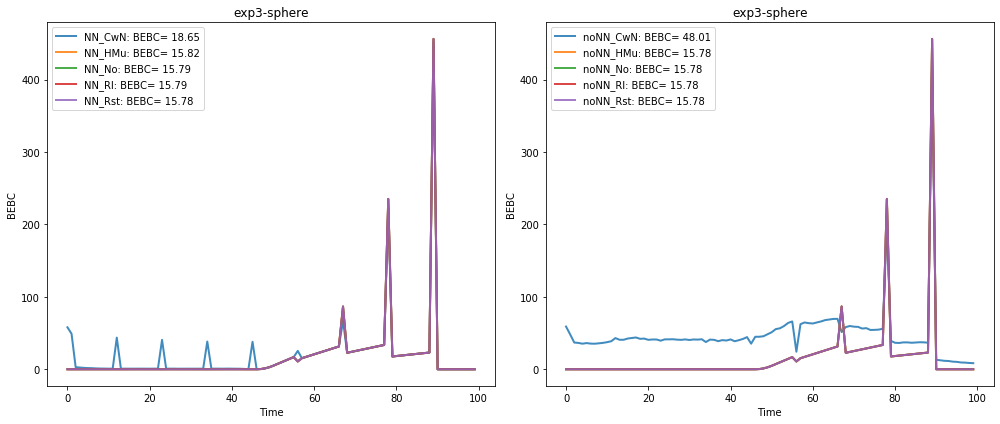

In [76]:
exp ='exp3'
func='sphere'
fig,ax = plt.subplots(1,2,figsize=(14,6))

plot_diff(exp, func, freq, ax[0], isnn=True)
plot_diff(exp, func, freq, ax[1], isnn=False)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Time')
ax[1].set_xlabel('Time')
ax[0].set_ylabel('BEBC')
ax[1].set_ylabel('BEBC')
ax[0].set_title(f'{exp}-{func}')
ax[1].set_title(f'{exp}-{func}')
plt.tight_layout()
fig.savefig(f'../../data/cluster_results/bebc{func}{exp}.eps', dpi=800, format='eps')

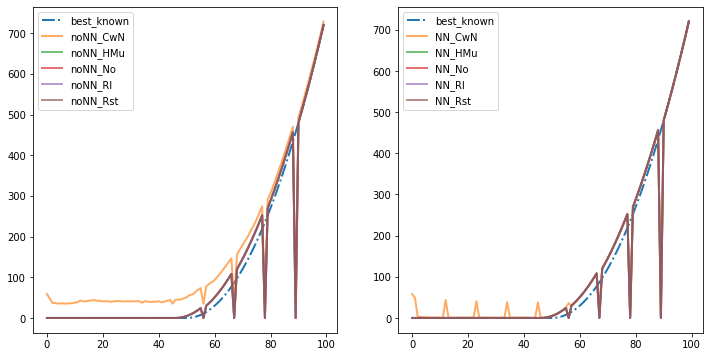

In [73]:
#one single plot
exp ='exp3'
func='sphere'
fig,ax = plt.subplots(1,2,figsize=(12,6))

plot_noNN(exp, func, freq, ax[0])
plot_NN(exp, func, freq, ax[1])

# fig.savefig(f'../../data/cluster_results/fitnesssep{exp}.eps', dpi=400, format='eps')

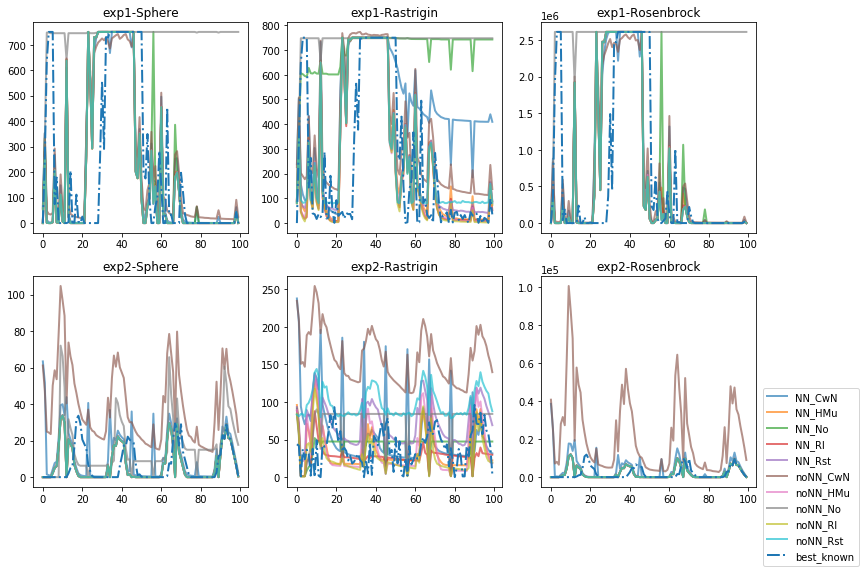

In [58]:
# one Plot
fig,axs = plt.subplots(2, 3, figsize=(12,8))#14,6 for only two plot

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='lower right', bbox_to_anchor=(1.4, -0.4, 0.1, 0.1))# bbox ``(x, y, width, height)``
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

# fig.savefig(f'../../data/cluster_results/fitnessall{freq_lbl}.eps', dpi=400, format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

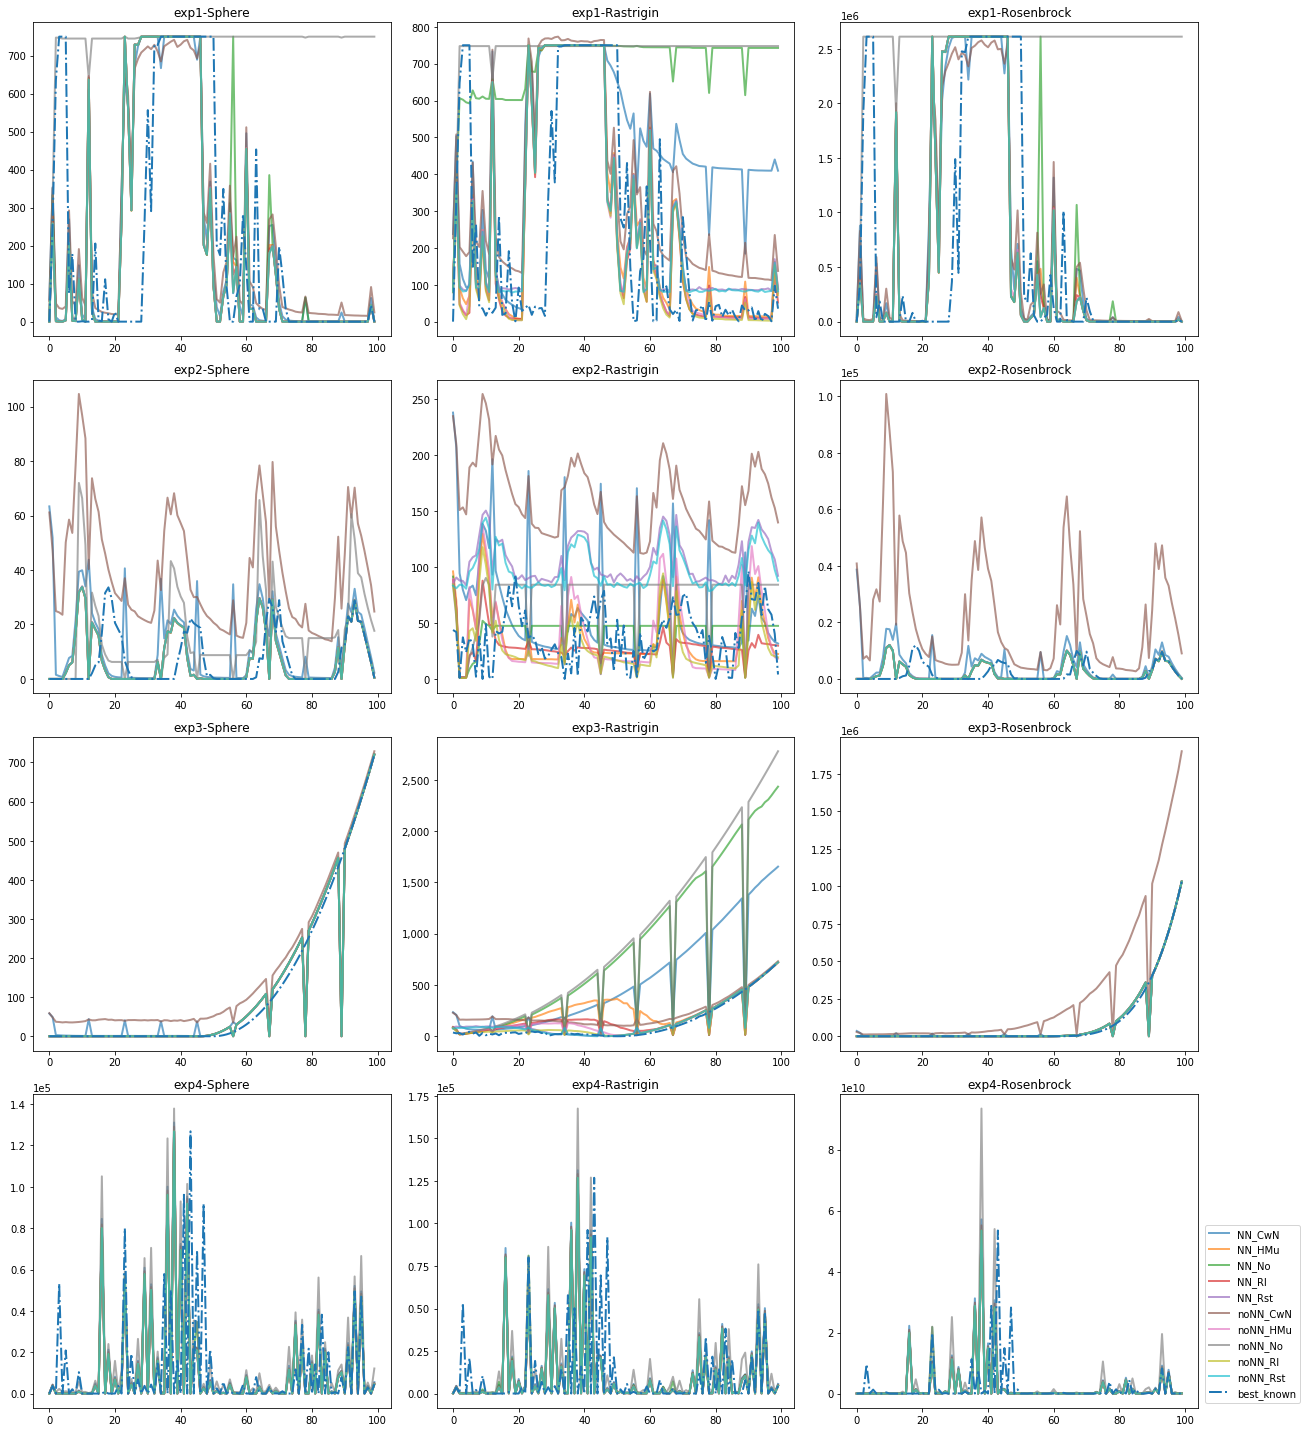

In [32]:
# all Plots together
fig,axs = plt.subplots(4, 3, figsize=(18,20))#14,6 for only two plot

for ax_row,exp in zip(axs,exps):
    for ax,func in zip(ax_row,funcs):
        plot_one(exp, func, freq, ax)
        # plot best
        best_values = best_knowns.query(f'experiment == {exp!r} and function=={func!r}').fitness.values
        ax.plot(best_values, lw=2, ls='-.', label='best_known')
        ax.set_title(f'{exp}-{func.title()}')
        ax.ticklabel_format(style='sci', scilimits=(0,5), useOffset=False)
        if ax.get_ylim()[1] < 1e5:
            ax.get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        
ax.legend(loc='lower right', bbox_to_anchor=(1.2, 0, 0.1, 0.1))# bbox ``(x, y, width, height)``
plt.tight_layout()
freq_lbl = f'{freq*10:02.0f}' if freq<1 else freq

fig.savefig(f'../../data/cluster_results/fitnessall{freq_lbl}.eps', dpi=400, format='eps')